In [43]:
import os
import importlib
import time

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
#from torchvision import transforms
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import load_data
import model

In [2]:
plt.style.use('Solarize_Light2')
%matplotlib inline
importlib.reload(load_data)
importlib.reload(model)

<module 'model' from '/home/uldo/work/kaggle/competitions/Human_Protein_Atlas_Image_Classification/code/model.py'>

In [3]:
W = H = 256

BATCH_SIZE = 100

LABEL_NAMES_MAP = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [4]:
def show(image, labels):
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(25,25), sharey=True)

    title = ""
    npimage = image.numpy()
    nplabels = labels.numpy()
    print(npimage.shape)
    print(nplabels)

    for i, label in enumerate(nplabels):
        if label == 1:
            if title == '':
                title += LABEL_NAMES_MAP[i]
            else:
                title += " & " + LABEL_NAMES_MAP[i]
    
    ax1.imshow(npimage[0,:,:],cmap="hot")
    ax1.set_title('Red')
    ax2.imshow(npimage[1,:,:],cmap="copper")
    ax2.set_title('Green')
    ax3.imshow(npimage[2,:,:],cmap="bone")
    ax3.set_title('Blue')
    ax4.imshow(npimage[3,:,:],cmap="afmhot")
    ax4.set_title('Yellow')
    f.suptitle(title, fontsize=20, y=0.62)
    

In [5]:
class HPA_ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(HPA_ConvNeuralNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 8, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear(int(16 * W/4 * H/4), 900)
        self.out2 = nn.Linear(900, 28)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        #return output, x
        return output

In [6]:
def init_weights(submodule):
    if type(submodule) == nn.Linear:
        nn.init.xavier_uniform_(submodule.weight)
        submodule.bias.data.fill_(0.01)

In [7]:
def prepare_loaders(dataset, valid_train_ratio=0.6):
    dataset_size = len(dataset)
    print("dataset_size: ", dataset_size)

    validation_subset_size = int(dataset_size * (1 - valid_train_ratio))
    print("validation_subset_size: ", validation_subset_size)

    indices = list(range(dataset_size))
    validation_indices = np.random.choice(indices, size=validation_subset_size, replace=False)
    train_indices = list(set(indices) - set(validation_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    dataset_sizes = {
            'train': len(train_indices),
            'validation': len(validation_indices)
        }

    train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler)
    validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler)

    loaders = {
            'train': train_loader,
            'validation': validation_loader
        }

    return loaders, dataset_sizes

In [8]:
def test(model, validation_loader, validation_dataset_size, criterion):
    model.eval()
    with torch.no_grad():
        
        correct_predicted_total = 0.0
        total_loss = 0.0
        total = 0.0
        
        for inputs, labels in validation_loader:
            inputs = inputs.to(device, dtype=torch.float)
            
            labels = labels.to(device, dtype=torch.uint8)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            predicted = outputs > 0

            total += labels.size(0)

            sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            item = sum_of_correct_predicted.item()

            correct_predicted_total += item

        print("total: ", total)
        accuracy = correct_predicted_total / total
        print(
                "Validation accuracy of the model on the {} validation images: {} ".format(
                    validation_dataset_size,
                    accuracy
                )
            )

    return accuracy

In [9]:
def validate(model, validation_loader, criterion):
    model.eval()
    with torch.no_grad():
        
        correct_predicted_total = 0.0
        total_loss = 0.0
        #total = 0.0
        
        for inputs, labels in validation_loader:
            inputs = inputs.to(device, dtype=torch.float)
            #labels_as_float = labels.to(device, dtype=torch.float)
            #labels = labels.to(device, dtype=torch.uint8)
            labels = labels.to(device, dtype=torch.float)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            #loss = criterion(outputs, labels_as_float)
            total_loss += loss.item() * inputs.size(0)
            
            predicted = outputs > 0

            #total += labels.size(0)
            labels = labels.data.byte()
            sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            item = sum_of_correct_predicted.item()

            correct_predicted_total += item

        #accuracy = correct_predicted_total / total
        accuracy = correct_predicted_total
        

    return (total_loss, accuracy)

In [10]:
def one_epoch_model_process(model, loader, criterion, optimizer=None):
    accuracy = 0.0
    total_loss = 0.0

    for inputs, labels in loader:
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        outputs = model(inputs)
            
        loss = criterion(outputs, labels)
        if optimizer:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * inputs.size(0)
            
        predicted = outputs > 0

        labels = labels.data.byte()
        torch_sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
        correct_predicted = torch_sum_of_correct_predicted.item()

        accuracy += correct_predicted        

    return (total_loss, accuracy)

In [11]:
def train_model(num_of_epoch, model, dataset_loaders, dataset_sizes, criterion, optimizer):
    torch.cuda.empty_cache()
    since = time.time()
    
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    for epoch in range(num_of_epoch):
        pass   

In [12]:
def run_model(model, batch):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    inputs = batch
    #inputs = inputs.to(device, dtype=torch.float)
    inputs = batch.to(device, dtype=torch.float)
    outputs = model(inputs)

In [13]:
def save_model(model, full=True, name='model'):
    if not full:
        torch.save(model.state_dict(), '{}_params.pkl'.format(name))
    else:
        torch.save(model, '{}.pkl'.format(name))
    return

In [14]:
def restore_model(name='model'):
    return torch.load('{}.pkl'.format(name))

In [15]:
train_df = load_data.load_text_data('../input/train.csv')

In [16]:
print(train_df.shape)

(31072, 2)


In [17]:
dataset = load_data.HumanProteinAtlasDataset(
    train_df,
    transform=load_data.transforms.ToTensor()
)

In [18]:
dataset_loaders, dataset_sizes = prepare_loaders(dataset)

dataset_size:  31072
validation_subset_size:  12428


In [19]:
train_loader = dataset_loaders['train']
validation_loader = dataset_loaders['validation']
train_dataset_size = dataset_sizes['train']
validation_dataset_size = dataset_sizes['validation']

In [20]:
print(train_dataset_size)
print(validation_dataset_size)

18644
12428


In [21]:
print(train_loader)

In [22]:
train_iter = iter(train_loader)

In [23]:
print(type(train_iter))

<class 'torch.utils.data.dataloader._DataLoaderIter'>


In [24]:
images, labels = train_iter.next()

In [25]:
print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([100, 4, 256, 256])
labels shape on batch size = torch.Size([100, 28])


(4, 256, 256)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


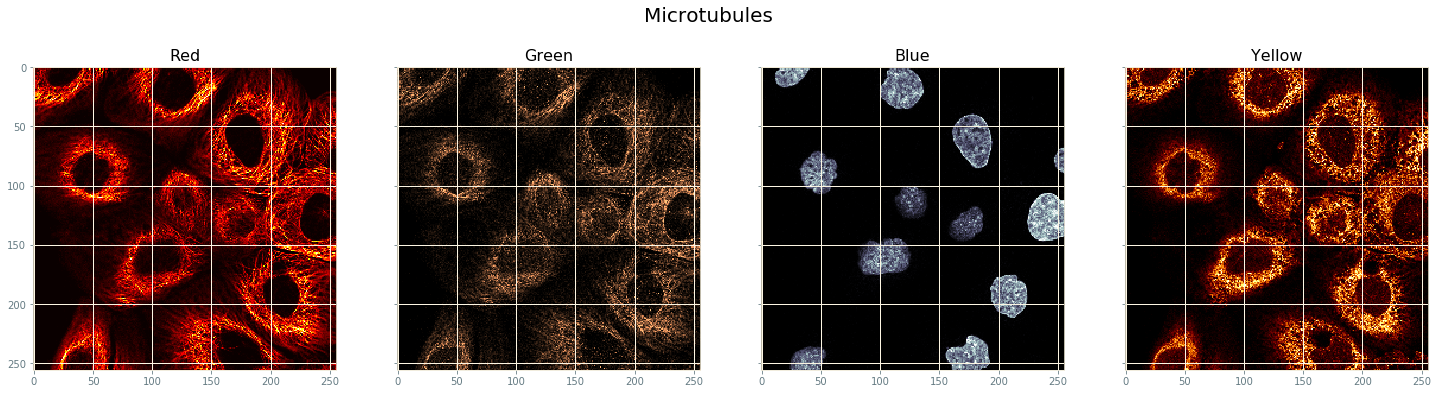

In [26]:
show(images[0], labels[0])

In [27]:
hpa_conv_neural_net = HPA_ConvNeuralNet()
hpa_conv_neural_net.apply(init_weights)

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


HPA_ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (out1): Linear(in_features=65536, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
print(device)

cuda:0


In [30]:
hpa_conv_neural_net.to(device)

HPA_ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (out1): Linear(in_features=65536, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [31]:
criterion=nn.BCEWithLogitsLoss(reduction='sum')
optimizer = optim.Adam(hpa_conv_neural_net.parameters(), lr=0.001, betas=(0.9, 0.99))

In [32]:
num_of_epoch = 4
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

In [33]:
torch.cuda.empty_cache()
since = time.time()
for epoch in range(num_of_epoch):
    epoch_train_accuracy = 0.0
    epoch_train_loss = 0.0
    correct_predicted_total = 0.0
    train_loss = 0.0
    #total_loss = 0.0
    #total = 0.0
    for i, data_batch in enumerate(train_loader, 0):
        
        inputs, labels = data_batch
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        
        outputs = hpa_conv_neural_net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
        predicted = outputs > 0

        #total += labels.size(0)
        labels = labels.data.byte()
        sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
        item = sum_of_correct_predicted.item()
        correct_predicted_total += item
        
    epoch_train_loss = train_loss / train_dataset_size
    epoch_train_accuracy = correct_predicted_total / train_dataset_size
    
    validation_loss, validation_accuracy = validate(hpa_conv_neural_net, validation_loader, criterion)
    
    epoch_validation_loss = validation_loss / validation_dataset_size
    epoch_validation_accuracy = validation_accuracy / validation_dataset_size
    
    print("Epoch {}: train loss {}, train accuracy"
          " {}, validation loss {}, validation accuracy {}".format(
              epoch + 1,
              epoch_train_loss,
              epoch_train_accuracy,
              epoch_validation_loss,
              epoch_validation_accuracy
        )
    )
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    validation_losses.append(epoch_validation_loss)
    validation_accuracies.append(epoch_validation_accuracy)
            
print("Finished Training")
time_elapsed = time.time() - since
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

Epoch 1: train loss 508.51915492328084, train accuracy 0.015822784810126583, validation loss 472.5680718767248, validation accuracy 0.020679111683295785
Epoch 2: train loss 448.9319283846135, train accuracy 0.051705642565972966, validation loss 462.63303694220116, validation accuracy 0.03765690376569038
Epoch 3: train loss 394.4211962277785, train accuracy 0.09901308732031752, validation loss 499.17044089973876, validation accuracy 0.05511747666559382
Epoch 4: train loss 293.20831541737834, train accuracy 0.25048272902810553, validation loss 560.8638274527685, validation accuracy 0.06984229159961378
Finished Training
Training complete in 46m 52s


In [34]:
#torch.cuda.empty_cache()
#validation_accuracy = validate(hpa_conv_neural_net, validation_loader, validation_dataset_size)

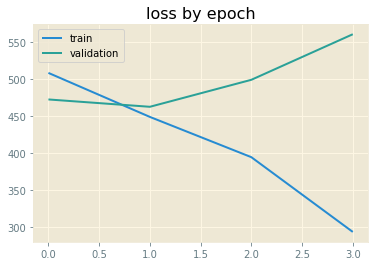

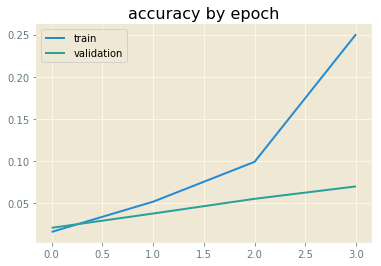

In [35]:
plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot(np.arange(len(validation_losses)), validation_losses, label='validation')
plt.legend()
plt.title("loss by epoch")
plt.show()

plt.plot(np.arange(len(train_accuracies)), train_accuracies, label='train')
plt.plot(np.arange(len(validation_accuracies)), validation_accuracies, label='validation')
plt.legend()
plt.title("accuracy by epoch")
plt.show()

In [36]:
save_model(hpa_conv_neural_net, full=True, name='hpa_conv_neural_net_2019-01-09-2')

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type HPA_ConvNeuralNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [37]:
!ls -lh

итого 1,2G
-rw-r--r-- 1 uldo uldo 1,8M дек 15 14:41 4-channel-resnet-from-scratch-pytorch-lb-0-16-1.ipynb
-rw-r--r-- 1 uldo uldo  15K дек 13 19:33 4-channel-resnet-from-scratch-pytorch-lb-0-16.ipynb
-rw-r--r-- 1 uldo uldo 2,1K янв  3 21:28 another_torch_validation_example.py
-rw-r--r-- 1 uldo uldo  29K дек  7 19:11 baseline-u-net-on-pytorch.py
-rw-r--r-- 1 uldo uldo  91M дек 15 13:49 bestmodel_1_0.49606512784957885.torch
-rw-r--r-- 1 uldo uldo  91M дек 13 19:34 bestmodel_1_0.5092800498008728.torch
-rw-r--r-- 1 uldo uldo  67K дек 23 19:14 cifar10_tutorial.ipynb
-rw-r--r-- 1 uldo uldo  12K дек 23 18:51 cifar10_tutorial.py
-rw-r--r-- 1 uldo uldo 226M янв  2 20:30 cnn.pkl
drwxr-xr-x 3 uldo uldo 4,0K дек 23 18:59 data
-rw-r--r-- 1 uldo uldo 6,0M дек 15 20:04 first_exp_eda-1.ipynb
-rw-r--r-- 1 uldo uldo 3,3M дек 13 11:31 first_exp_eda.ipynb
-rw-r--r-- 1 uldo uldo 2,4K дек 15 20:17 first_exp_model_with_pytorch.py
-rw-r--r-- 1 uldo uldo 226M янв  7 23:18 hpa_conv_neural_net_1.pkl
-rw-r--r-- 1 

In [38]:
test_df = load_data.load_text_data('../input/sample_submission.csv')

In [39]:
test_dataset = load_data.HumanProteinAtlasDataset(
    train_df,
    transform=load_data.transforms.ToTensor(),
    train_mode=False
)

In [42]:
print(type(data))
print(data)

<class 'list'>
[tensor([[[[0.2227, 0.2266, 0.2500,  ..., 0.0078, 0.0820, 0.1797],
          [0.1094, 0.0508, 0.1914,  ..., 0.0742, 0.0938, 0.0273],
          [0.0586, 0.0586, 0.2070,  ..., 0.0781, 0.0039, 0.0352],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3867, 0.1562, 0.3555],
          [0.0000, 0.0000, 0.0000,  ..., 0.8359, 0.6367, 0.3867],
          [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.5156, 0.5234]],

         [[0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0195, 0.0352],
          [0.0352, 0.0000, 0.5430,  ..., 0.0234, 0.2539, 0.0156],
          [0.0586, 0.0273, 0.0000,  ..., 0.1406, 0.2344, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6719, 0.3281, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.5195, 0.0273, 0.4492],
          [0.0000, 0.0000, 0.0000,  ..., 0.5156, 0.0820, 0.4688]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4492, 0.4102, 0.4453],
          [0.0000, 0.0000, 0.0000,  ..., 0.4102, 0.2383, 0.2695],
          [0.0000, 0.0000,

In [44]:
test_loader = data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=1)

In [45]:
ids = []
predictions = []
hpa_conv_neural_net = hpa_conv_neural_net.cuda()

for test_data_batch in test_loader:
    test_input, _ = test_data_batch
    test_output = run_model(hpa_conv_neural_net, test_input)
    batch_predictions = []
    
    test_output = test_output.detach().numpy()
    
    for sample in test_output:
        prediction = ''
        for i, label in enumerate(sample):
            if label > 0:
                prediction += ' ' + str(i)
                print(prediction)
            if prediction = '':
                prediction = '0'
            else:
                prediction = prediction[1:]
            batch_predictions.append(prediction)
    ids += list(test_data_batch['Id'])
    predictions += batch_predictions
                    

In [ ]:
print(predictions)

In [ ]:
submission_df = pd.DataFrame({'Id': ids, 'Predicted': predictions})

In [ ]:
submission_df.to_csv('protein_classification', header=True, index=False)